In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import json

from tqdm import tqdm
from sklearn.metrics import average_precision_score, precision_recall_curve

from torch.utils.data import Dataset
import skimage
from PIL import Image
from copy import deepcopy
from sklearn.utils.fixes import signature
import time
import pickle
import nltk

plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.set_printoptions(precision=2, suppress=True)

In [2]:
class AnswerDisDataset(Dataset):
    def __init__(self, dataset_name, split):
        super(AnswerDisDataset, self).__init__()
        
        self.image_dir = None
        if dataset_name == 'vqa_2.0':
            self.image_dir = '/home/qing/Desktop/Datasets/MSCOCO/images'
        elif dataset_name == 'vizwiz':
            self.image_dir = '/home/qing/Desktop/Datasets/VizWiz/v1/data/Images'
        self.image_ext = '.jpg'
        
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'trainval': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
        
        self.transform = data_transforms[split]
        self.word2vocab_id = json.load(open('word2vocab_id.json'))
        self.ans2id = json.load(open('ans2id.json'))
        
        dataroot='../data'
        dataset = json.load(open(os.path.join(dataroot, '%s_%s.json'%(dataset_name, split))), encoding='cp1252')
        max_length = 20
        for sample in dataset:
            question = sample['question']
            question = question.lower()
            tokens = nltk.word_tokenize(question)
            tokens = [self.word2vocab_id[x] for x in tokens if x in self.word2vocab_id]
            tokens = tokens[:max_length]
            if len(tokens) < max_length:
                # Note here we pad in front of the sentence
                padding = [0] * (max_length - len(tokens))
                tokens = padding + tokens
            sample['q_token'] = tokens
            
            tokens = [x.lower() for x in sample['answers']]
            tokens = [self.ans2id[x] for x in tokens if x in self.ans2id]
            sample['a_token'] = tokens
        self.dataset = dataset
        
        
    def __getitem__(self, index):
        entry = self.dataset[index]
        image = entry['image']
        image_path = os.path.join(self.image_dir, image.replace('.jpg', self.image_ext))
        with open(image_path, 'rb') as f:
            image = Image.open(f).convert('RGB')
        label = [0 if x < 2 else 1 for x in entry['ans_dis_labels']]
        label = torch.tensor(label, dtype=torch.float32)
        
        question = torch.from_numpy(np.array(entry['q_token']))
        answer = np.zeros((len(self.ans2id),), dtype=np.float32)
        for ans in entry['a_token']:
            answer[ans] += 1.0
        answer /= 10.0
        answer = torch.from_numpy(answer)
        
        if self.transform:
            image = self.transform(image)

        return image, question, answer, label, image_path, index
    
    def __len__(self):
        return len(self.dataset)
    

splits = ['train', 'val', 'test']
datasets = {}
datasets.update({x: AnswerDisDataset('vizwiz', x) for x in splits})
dataset_sizes = {x: len(datasets[x]) for x in splits}
print(dataset_sizes)

{'test': 7501, 'train': 19502, 'val': 3001}


In [3]:
from language_model import WordEmbedding, QuestionEmbedding
from fc import FCNet
from torch.nn.utils.weight_norm import weight_norm

class Identity(nn.Module):
    def __init__(self, dim):
        super(Identity, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x

def init_image_model(init_model_path=None):
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = Identity(num_ftrs)
    
    if init_model_path:
        model.load_state_dict(torch.load(init_model_path))
    model = model.to(device)
    return model

class BaseModel(nn.Module):
    def __init__(self, w_emb, q_emb, q_net, v_net, a_net, classifier, model_type='Q+I'):
        super(BaseModel, self).__init__()
        self.w_emb = w_emb
        self.q_emb = q_emb
        self.q_net = q_net
        self.v_net = v_net
        self.a_net = a_net
        self.classifier = classifier
        self.model_type = model_type

    def forward(self, v, q, a):
        """Forward

        return: logits, not probs
        """
        w_emb = self.w_emb(q)
        q_emb = self.q_emb(w_emb) # [batch, q_dim]

        q_repr = self.q_net(q_emb)
        v_repr = self.v_net(v)
        a_repr = self.a_net(a)
        
        model_type = self.model_type
        if model_type == 'I':
            joint_repr = v_repr
        elif model_type == 'Q':
            joint_repr = q_repr
        elif model_type == 'A':
            joint_repr = a_repr
        elif model_type == 'Q+I':
            joint_repr = q_repr * v_repr
        elif model_type == 'Q+I+A':
            joint_repr = (q_repr + v_repr + a_repr) / 3
        elif model_type == 'Q+A':
            joint_repr = q_repr * a_repr
        logits = self.classifier(joint_repr)
        return logits
    
class FullModel(nn.Module):
    def __init__(self, image_model, base_model):
        super(FullModel, self).__init__()
        self.image_model = image_model
        self.base_model = base_model
        
    def forward(self, img, q, a):
        x = self.image_model(img)
        x = self.base_model(x, q, a)
        return x

def init_model(model_type='Q+I'):
    num_hid = 300
    image_model = init_image_model()
    w_emb = WordEmbedding(len(datasets['train'].word2vocab_id), 300, 0.0)
    w_emb.init_embedding('glove6b_init_300d.npy')
    q_emb = QuestionEmbedding(300, num_hid, 1, False, 0.0)
    q_net = FCNet([num_hid, num_hid])
    v_net = FCNet([image_model.fc.dim, num_hid])
    a_net = FCNet([len(datasets['train'].ans2id), num_hid])
    classifier = weight_norm(nn.Linear(num_hid, 10), dim=None)

    base_model = BaseModel(w_emb, q_emb, q_net, v_net, a_net, classifier, model_type)
    base_model = base_model.to(device)
    model = FullModel(image_model, base_model)
    return model

In [4]:
model_type = 'Q+I+A'
model = init_model(model_type)
model.load_state_dict(torch.load('./saved_models/Q+I+A_train-on-(train,val).pt'))

In [5]:
data_loader = torch.utils.data.DataLoader(datasets['train'], shuffle=True, batch_size=1)

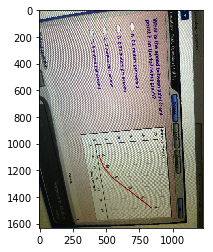

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000024933.jpg
What is this?
[u'survey question graph', u'unanswerable', u'computer screen', u'computer screen', u'lap', u'test', u'line graph', u'graph', u'computer test', u'computer screen']
[0, 0, 0, 0, 5, 0, 4, 4, 0, 0]
[[0.04 0.11 0.02 0.03 0.96 0.03 0.91 0.97 0.   0.  ]]



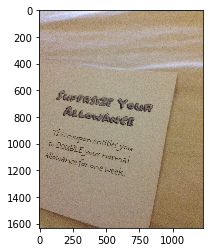

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000011073.jpg
what does this piece of paper say 
[u'supersize your allowance this coupon entitles you to double your normal allowance for 1 week', u'supersize your allowance', u'supersize your allowance', u'supersize your allowance this coupon entitles you to double your normal allowance for 1 week', u'supersize your allowance', u'supersize your allowance this coupon entitles you to double your normal allowance for 1 week', u'supersize your allowance: this coupon entitles you to double your normal allowance for 1 week', u'supersize you allowance', u'supersize your allowance this coupon entitles you to double your normal allowance for 1 week', u'supersize your allowance this coupon entitles you to double your normal allowance for 1 week']
[0, 0, 0, 0, 1, 0, 2, 4, 0, 1]
[[0.03 0.04 0.01 0.02 0.95 0.04 0.94 0.98 0.   0.  ]]



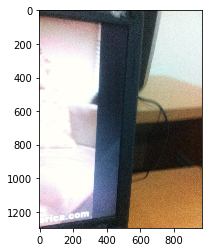

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000009805.jpg
What's this?
[u'computer monitor', u'tv', u'tv', u'tv', u'tv', u'unanswerable', u'computer screen', u'unsuitable', u'television', u'edge computer']
[2, 2, 2, 0, 2, 0, 0, 2, 0, 0]
[[0.09 0.18 0.03 0.02 0.94 0.03 0.87 0.95 0.   0.  ]]



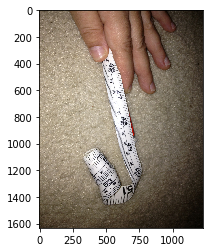

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000024228.jpg
What's the length of a cane?
[u'49', u'unanswerable', u'unanswerable', u'49 inches', u'46 inches', u'49 inch', u'49', u'49', u'49', u'unanswerable']
[0, 2, 0, 0, 1, 0, 1, 4, 0, 0]
[[0.14 0.32 0.06 0.05 0.82 0.05 0.68 0.81 0.01 0.  ]]



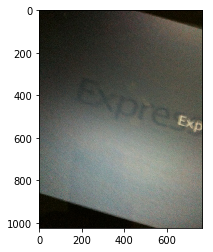

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000002666.jpg
Can you please tell me if there is anything on this computer screen.
[u'image says express', u'unanswerable', u'express card', u'express', u'word express', u'express', u'express', u'express', u'express', u'express']
[0, 1, 0, 1, 4, 0, 4, 3, 0, 1]
[[0.16 0.08 0.04 0.01 0.92 0.04 0.89 0.94 0.01 0.  ]]



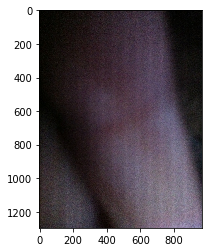

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000002558.jpg
This is Carla Gilbread, and I'm a participant in the clothing study. 
[u'unanswerable', u'i dont know', u'unsuitable', u'unanswerable', u'grey white pinstripe', u'unsuitable', u'unanswerable', u'unanswerable', u'unanswerable', u'unanswerable']
[2, 1, 1, 1, 1, 0, 1, 1, 1, 0]
[[0.63 0.68 0.53 0.04 0.48 0.08 0.16 0.2  0.01 0.  ]]



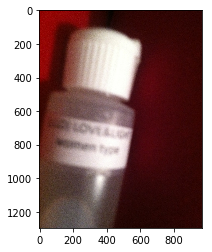

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000004824.jpg
What fragrance is this?
[u'love', u'unsuitable', u'unsuitable', u'unanswerable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable']
[2, 1, 1, 1, 1, 0, 1, 2, 0, 0]
[[0.7  0.78 0.27 0.02 0.54 0.02 0.27 0.39 0.   0.  ]]



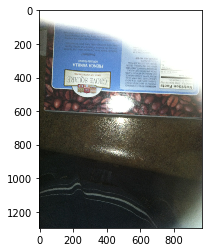

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000008438.jpg
What kind of K cup?
[u'unanswerable', u'french vanilla', u'french vanilla', u'french vanilla', u'french vanilla', u'unanswerable', u'french vanilla', u'french vanilla', u'french vanilla', u'french vanilla']
[3, 3, 0, 0, 0, 0, 1, 0, 0, 0]
[[0.16 0.29 0.05 0.04 0.86 0.03 0.76 0.89 0.01 0.  ]]



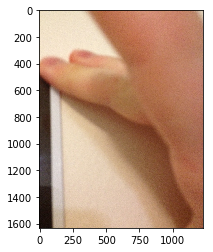

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000007433.jpg
Please tell me what kind of card this is.
[u'unsuitable', u'unanswerable', u'unanswerable', u'unanswerable', u'unanswerable', u'unanswerable', u'unsuitable', u'unsuitable', u'unanswerable', u'unanswerable']
[4, 1, 0, 1, 0, 0, 0, 0, 0, 0]
[[0.71 0.91 0.65 0.14 0.4  0.02 0.15 0.21 0.01 0.  ]]



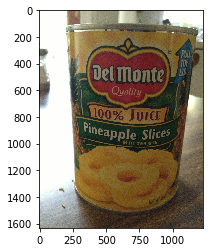

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000002449.jpg
What type of fruit is this? What brand is it and what is the net weight? 
[u'pineapple', u'unanswerable', u'del monte pineapple slices net weight unreadable', u'del monte pineapple slices', u'pineapple', u'del monte pineapple slices', u'del monte pineapple slices no weight visible', u'pineapple del monte', u'unsuitable', u'delmonte pineapple 20 oz']
[0, 0, 0, 1, 4, 0, 5, 5, 0, 0]
[[0.03 0.13 0.02 0.02 0.88 0.02 0.86 0.96 0.   0.  ]]



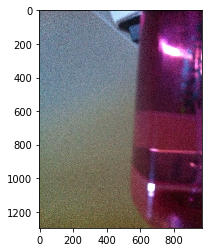

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000026839.jpg
What kind of body spray is this?
[u'pink', u'unanswerable', u'unanswerable', u'unsuitable', u'mennen', u'unanswerable', u'strawberry', u'unanswerable', u'unanswerable', u'perfume']
[3, 4, 1, 0, 2, 0, 2, 1, 1, 0]
[[0.4  0.75 0.19 0.06 0.65 0.06 0.37 0.5  0.01 0.  ]]



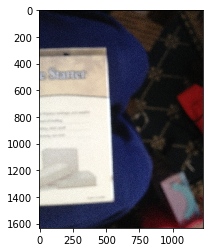

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000009722.jpg
What is this item?
[u'seat cushion', u'unanswerable', u'fire starter', u'unanswerable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'lap']
[3, 1, 0, 1, 1, 0, 2, 1, 1, 0]
[[0.48 0.7  0.2  0.04 0.71 0.02 0.45 0.62 0.   0.  ]]



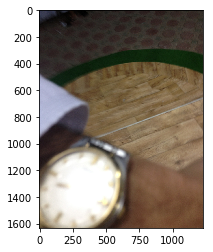

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000001305.jpg
what's this?
[u'wrist watch', u'watch', u'watch', u'watch', u'watch', u'wristwatch', u'wristwatch', u'watch', u'wrist watch', u'watch']
[0, 1, 0, 0, 5, 0, 5, 4, 0, 0]
[[0.04 0.04 0.01 0.01 0.94 0.04 0.93 0.98 0.01 0.  ]]



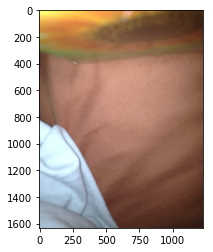

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000022405.jpg
What is this? 
[u'unanswerable', u'blanket', u'unanswerable', u'unanswerable', u'pillow', u'clothing', u'unanswerable', u'unanswerable', u'this cloth', u'unsuitable']
[3, 0, 0, 0, 0, 1, 1, 2, 0, 0]
[[0.52 0.7  0.28 0.06 0.68 0.05 0.46 0.58 0.01 0.  ]]



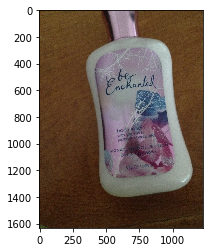

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000020841.jpg
What is this?
[u'body lotion', u'be enchanted body lotion', u'body lotion', u'body lotion', u'body lotion', u'lotion', u'lotion', u'body lotion', u'body lotion', u'body lotion']
[0, 0, 0, 0, 3, 0, 3, 5, 0, 0]
[[0.02 0.05 0.01 0.02 0.95 0.04 0.94 0.98 0.   0.  ]]



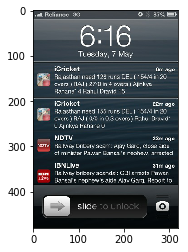

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000006126.jpg
What is this photo describing?
[u'cricket scores railway bribery scam', u'this photo describing news stories', u'phone notifications', u'lock screen notifications from cricket ndtv ibn live', u'news', u'news headlines', u'messages', u'news updates', u'rajasthan need 128 runs rajasthan need 155 runs railway bribery scam', u'news updates']
[0, 0, 0, 1, 4, 0, 4, 4, 0, 0]
[[0.01 0.04 0.01 0.02 0.97 0.03 0.95 0.99 0.   0.  ]]



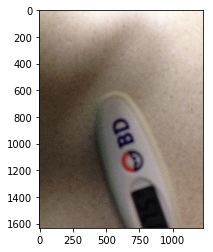

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000025249.jpg
What does this say?
[u'bd', u'bd', u'bd', u'bd', u'unsuitable', u'bd', u'unsuitable', u'unsuitable', u'bd', u'bd']
[3, 2, 0, 0, 2, 0, 1, 1, 0, 0]
[[0.32 0.39 0.11 0.06 0.81 0.05 0.67 0.79 0.01 0.  ]]



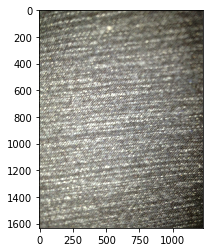

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000022868.jpg
What color is this?
[u'grey', u'black denim', u'grey', u'grey', u'grey', u'grey', u'grey white', u'grey', u'unanswerable', u'grey']
[0, 0, 0, 0, 4, 0, 2, 4, 2, 0]
[[0.05 0.03 0.01 0.01 0.96 0.14 0.93 0.96 0.   0.  ]]



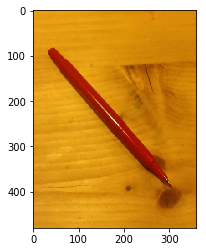

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000000834.jpg
I can't see anything.  Which color is this pen?  I hope I hear your voice, so I know it.
[u'red', u'red', u'red', u'red', u'red', u'red', u'red pen', u'red', u'red', u'red color pen']
[0, 0, 0, 0, 4, 2, 3, 3, 0, 0]
[[0.02 0.06 0.05 0.03 0.9  0.24 0.79 0.9  0.02 0.01]]



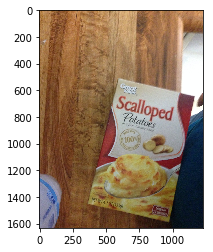

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000007420.jpg
What are these?
[u'scalloped potatoes', u'scalloped potatoes', u'scalloped potatoes', u'scalloped potatoes', u'boxed scalloped potatoes', u'scalloped potatoes', u'scalloped potatoes', u'scalloped potatoes', u'scalloped potatoes', u'dehydrated scalloped potatoes']
[0, 0, 0, 0, 1, 0, 1, 4, 0, 0]
[[0.03 0.08 0.02 0.02 0.93 0.04 0.91 0.97 0.01 0.  ]]



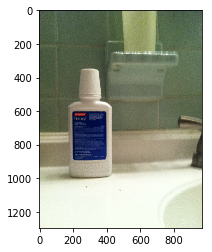

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000027954.jpg
What is in this bottle? Thank you.
[u'unsuitable', u'liquid paper', u'pepcid', u'mouth wash', u'unsuitable', u'peroxyl', u'mouth wash', u'colgate peroxyl mouthwash', u'colgate peroxyl', u'unsuitable']
[0, 1, 0, 1, 5, 1, 3, 3, 0, 0]
[[0.18 0.31 0.06 0.04 0.86 0.04 0.74 0.86 0.01 0.  ]]



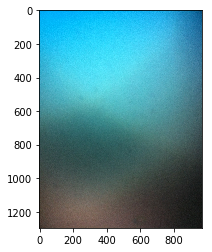

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000005987.jpg
What does this screen say
[u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unanswerable', u'unsuitable', u'nothing to say']
[2, 4, 3, 2, 1, 1, 1, 1, 0, 0]
[[0.87 0.78 0.5  0.07 0.32 0.04 0.16 0.18 0.01 0.  ]]



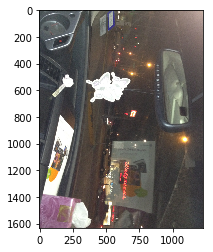

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000001623.jpg
What is that?
[u'unanswerable', u'car', u'stuff on dashboard', u'car interior', u'walgreens', u'dashboard car', u'walgreens', u'dashboard', u'windshield', u'unanswerable']
[1, 1, 0, 1, 4, 0, 4, 4, 0, 0]
[[0.06 0.18 0.03 0.02 0.94 0.05 0.87 0.95 0.   0.  ]]



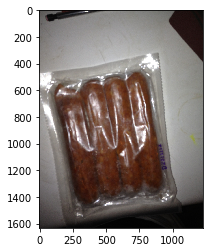

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000023942.jpg
Are these gourmet franks or polish sausages?
[u'gourmet franks', u'polish sausages', u'polish sausages', u'polish sausages', u'franks', u'franks', u'gourmet franks', u'polish sausages', u'gourmet franks', u'yes']
[0, 1, 0, 0, 5, 0, 5, 5, 0, 0]
[[0.04 0.09 0.03 0.01 0.88 0.06 0.82 0.94 0.01 0.01]]



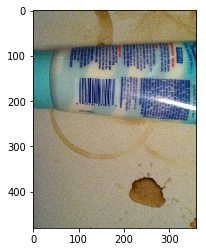

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000003059.jpg
The instructions for this cream, thank you.
[u'yes this cream', u'apply wet', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unsuitable', u'unanswerable', u'unsuitable', u'unanswerable']
[1, 2, 1, 0, 3, 0, 2, 3, 0, 0]
[[0.45 0.68 0.31 0.04 0.49 0.04 0.2  0.32 0.01 0.  ]]



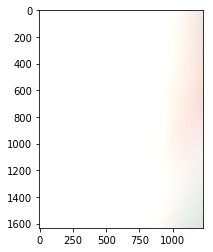

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000006468.jpg
Hi, my Mother was curious. What does a sighted person have to do to become involved with vizwiz? As far as being a web worker is concerned. Sorry, I know this isn't exactly what the app was made for, but, if could at least tell me I would really appreciate it.
[u'download app', u'unsuitable', u'email for more information', u'unanswerable', u'unanswerable', u'no clue', u'i dont know what vizwiz', u'from what i understand vizwiz hires people through amazon turk im turk worker', u'unsuitable', u'unanswerable']
[2, 2, 2, 0, 0, 0, 1, 0, 0, 0]
[[0.63 0.73 0.7  0.26 0.34 0.23 0.17 0.18 0.07 0.04]]



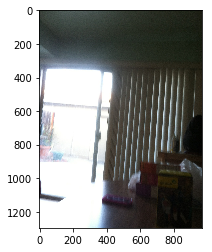

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000000884.jpg
What kind of cookies are these?
[u'girl scout', u'chocolate chip', u'unanswerable', u'unanswerable', u'girl scout', u'unsuitable', u'unanswerable', u'unanswerable', u'girl scouts', u'unsuitable']
[3, 1, 0, 0, 2, 1, 2, 2, 1, 0]
[[0.42 0.7  0.18 0.07 0.68 0.03 0.43 0.57 0.01 0.  ]]



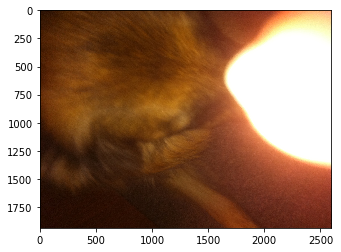

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000021114.jpg
What is that?
[u'fur', u'dog', u'dogs head', u'dog bright light', u'unanswerable', u'unsuitable', u'dog', u'hand', u'unsuitable', u'sandwich']
[1, 0, 0, 0, 4, 0, 4, 4, 0, 0]
[[0.26 0.26 0.07 0.03 0.85 0.05 0.76 0.87 0.01 0.  ]]



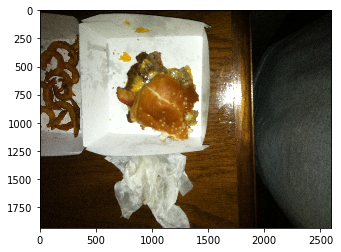

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000025152.jpg
what do you see?
[u'cheese burger fries', u'food', u'cheesteak sandwich', u'half eaten burger', u'food', u'half eaten burger fries', u'take out food', u'food', u'burger', u'half eaten cheeseburger']
[0, 0, 0, 0, 5, 1, 4, 5, 0, 0]
[[0.02 0.05 0.01 0.01 0.96 0.04 0.95 0.98 0.   0.  ]]



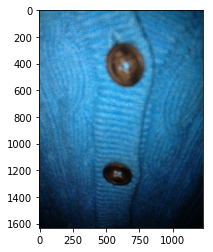

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000000677.jpg
What color is this?
[u'blue', u'blue', u'blue', u'blue', u'blue', u'blue', u'blue', u'light blue', u'blue', u'blue']
[0, 0, 0, 0, 0, 0, 3, 4, 0, 0]
[[0.02 0.03 0.01 0.01 0.97 0.13 0.93 0.97 0.   0.  ]]



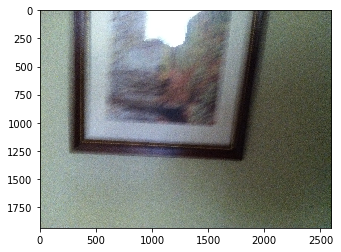

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000001408.jpg
Can you tell me what's in this picture on my wall?
[u'unsuitable', u'unsuitable', u'trees foliage', u'unsuitable', u'unsuitable', u'unsuitable', u'blurry', u'no', u'drawing', u'unsuitable']
[3, 1, 1, 0, 2, 1, 1, 2, 0, 0]
[[0.5  0.6  0.25 0.05 0.74 0.04 0.46 0.58 0.01 0.  ]]



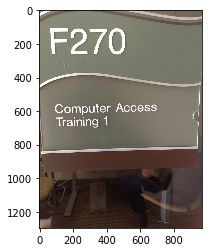

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000020267.jpg
Can you please tell me what classroom this is?
[u'computer access training 1', u'computer access training 1', u'f270 computer access training 1', u'f270 computer access training 1', u'computer access training 1', u'f270', u'f270', u'computer access training 1', u'computer access training 1', u'f270']
[0, 1, 1, 1, 4, 1, 2, 3, 0, 0]
[[0.02 0.07 0.01 0.02 0.96 0.05 0.94 0.98 0.01 0.  ]]



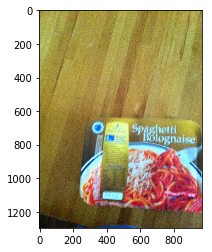

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000010168.jpg
How long do I cook this in the microwave? 
[u'unanswerable', u'1 min', u'10', u'unanswerable', u'unanswerable', u'unanswerable', u'8 minutes', u'10 minutes', u'4 minutes', u'unsuitable']
[3, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.29 0.7  0.22 0.05 0.58 0.07 0.34 0.5  0.02 0.01]]



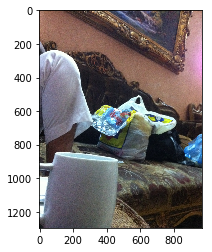

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000001589.jpg
Is it a glass
[u'mug', u'no', u'mug', u'yes', u'no', u'no', u'yes', u'mug', u'no', u'white mug']
[1, 0, 0, 0, 3, 2, 1, 4, 0, 1]
[[0.05 0.29 0.14 0.04 0.86 0.13 0.59 0.77 0.01 0.  ]]



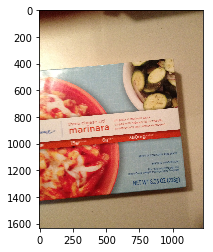

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000026643.jpg
What is this product?
[u'3 cheese ziti marinara', u'3 cheese marinara', u'marinara', u'3 cheese ziti marinara', u'3 cheese ziti marinara', u'marinara', u'frozen meal 3 cheese ziti marinara', u'pasta', u'pasta', u'3 cheese ziti marinara']
[0, 0, 0, 0, 5, 0, 5, 5, 0, 0]
[[0.03 0.06 0.01 0.02 0.94 0.03 0.94 0.98 0.01 0.  ]]



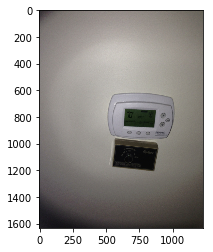

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000005431.jpg
What are the bottom buttons from left to right on the thermometer panel?
[u'unanswerable', u'unanswerable', u'unanswerable', u'unsuitable', u'unknown', u'unsuitable', u'unanswerable', u'unsuitable', u'unanswerable', u'unsuitable']
[3, 3, 2, 0, 2, 1, 1, 1, 0, 0]
[[0.67 0.88 0.55 0.08 0.43 0.06 0.12 0.18 0.01 0.  ]]



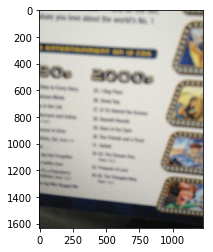

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000002784.jpg
What is this box?
[u'unanswerable', u'unsuitable', u'movie', u'unanswerable', u'unsuitable', u'dvd', u'unanswerable', u'unsuitable', u'unsuitable', u'dvd']
[1, 2, 2, 0, 2, 1, 1, 2, 0, 0]
[[0.48 0.68 0.25 0.06 0.7  0.02 0.45 0.62 0.   0.  ]]



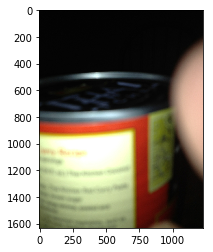

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000009250.jpg
What is this?
[u'unsuitable', u'unsuitable', u'unanswerable', u'unanswerable', u'can', u'can food', u'unanswerable', u'canned food', u'unsuitable', u'unsuitable']
[4, 3, 1, 1, 0, 1, 1, 0, 1, 0]
[[0.5  0.71 0.26 0.04 0.68 0.02 0.43 0.6  0.   0.  ]]



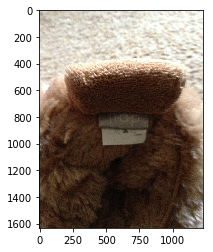

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000002028.jpg
Can't the brand be read off this tag, or anything off this tag be read, thanks
[u'n*a*p', u'no', u'nap', u'brand can be read', u'nap', u'nap', u'nap', u'n p', u'nap', u'unanswerable']
[0, 0, 0, 1, 4, 0, 3, 4, 0, 0]
[[0.04 0.15 0.03 0.03 0.95 0.05 0.89 0.95 0.   0.  ]]



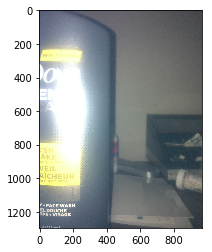

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000024246.jpg
What is this?
[u'face wash', u'face wash', u'body wash', u'dove face wash', u'soap', u'face wash', u'face wash', u'wash for body face', u'this dove men care body face wash', u'soap']
[1, 0, 0, 0, 4, 0, 5, 4, 0, 0]
[[0.05 0.06 0.01 0.01 0.95 0.03 0.94 0.98 0.   0.  ]]



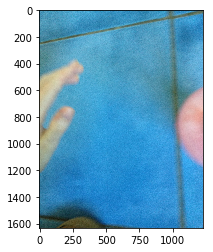

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000003033.jpg
What is this button?
[u'unanswerable', u'unanswerable', u'unsuitable', u'unanswerable', u'unsuitable', u'i dont know', u'unsuitable', u'off', u'shirt', u'unanswerable']
[2, 2, 1, 0, 1, 0, 1, 0, 1, 0]
[[0.6  0.71 0.25 0.03 0.64 0.03 0.39 0.53 0.   0.  ]]



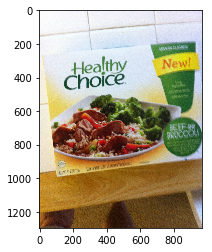

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000011878.jpg
Cold you please tell me what type of Hea;thy Choice dinner this is? Thanks
[u'frozen food', u'beef broccoli', u'beef andbroccoli', u'beef broccoli', u'beef broccoli', u'beef broccoli', u'beef broccoli', u'beef broccoli', u'beef broccoli', u'beef broccoli']
[1, 0, 0, 0, 2, 0, 2, 4, 0, 0]
[[0.03 0.04 0.01 0.01 0.95 0.05 0.94 0.98 0.   0.  ]]



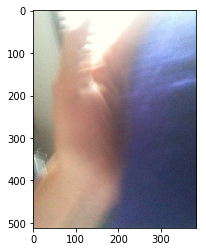

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000020713.jpg
Color is this.
[u'blue', u'blue', u'blue', u'blue', u'unsuitable', u'blue', u'blue', u'unanswerable', u'royal blue', u'unsuitable']
[2, 2, 1, 0, 3, 0, 2, 3, 0, 0]
[[0.3  0.13 0.11 0.01 0.89 0.12 0.75 0.82 0.01 0.  ]]



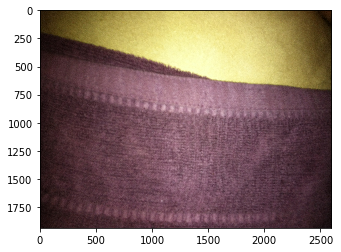

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_train_000000008571.jpg
Can you tell what color the cloth is?
[u'purple', u'purple', u'purple', u'purple', u'purple', u'purple', u'maroon', u'purple', u'purple', u'purple']
[0, 0, 0, 0, 2, 1, 3, 4, 0, 0]
[[0.02 0.03 0.01 0.01 0.97 0.11 0.95 0.98 0.   0.  ]]



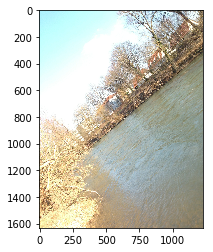

/home/qing/Desktop/Datasets/VizWiz/v1/data/Images/VizWiz_test_000000026507.jpg
Is the water visible?
[u'yes', u'yes', u'yes', u'yes', u'yes', u'yes', u'yes', u'yes', u'yes', u'yes']
[0, 0, 0, 0, 1, 0, 1, 1, 1, 4]
[[0.12 0.57 0.39 0.11 0.74 0.25 0.39 0.52 0.03 0.01]]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model.eval()

for images, questions, answers, labels, image_paths, ids in data_loader:
    
    img = mpimg.imread(image_paths[0])
    plt.imshow(img)
    plt.show()
    
    print(image_paths[0])
    print(data_loader.dataset.dataset[ids[0].item()]['question'])
    print(data_loader.dataset.dataset[ids[0].item()]['answers'])
    print(data_loader.dataset.dataset[ids[0].item()]['ans_dis_labels'])
    images = images.to(device)
    questions = questions.to(device)
    labels = labels.to(device)
    answers = answers.to(device)
    outputs = model(images, questions, answers)
    outputs = outputs.sigmoid()
    print(outputs.cpu().detach().numpy())
    raw_input()